# Compare Two Mean-Reversal Strategies 
*Xiaoqiong(Joan) Zhang*

I will compare the performance of three different stragegies - Buy and Hold Market Portflio, Mean-Reversal Volatility-Based Weight Portfolio, Mean-Reversal Return-Based Asset Portfolio that I learned recently. The back-test data is from the 1999-01-04 to 2019-10-08.

**Strategy0: Buy and Hold Market Strategy: Hold the S&P 500 to obtain the market return.**


**Strategy1: MeanR_VOL Strategy: The weight of risky asset is based on the difference of daily and weekly volatility.**

$$Weight_{t+1} = -2*(r_{t-3} + 2r_{t-2} +3r_{t-1} +4r_t)*10$$

*Following steps of Strategy1:*
1. Get the daily return of market
2. Calculate how much the position we will hold the market based on the weight formula.
3. Calculate the portflio performance

**Strategy2: MeanR_RET Strategy: Buy bottom 20% stocks and sell the top 20% stocks among s&P500 all stocks.**

* Sell or buy back the stocks when they are out of the 40% quantile to reduct the turnover of portfolio to reduce the transaction cost in reality.

* I add one day interval to make the strategy more realistic. This is to say, the strategy would buy and sell stocks at day T based on the stocks' performance at day T-2. This is because it's hard for us to buy or sell stocks at the last moment of the trading day. It might be better to use Intraday price. I will add 24 hours to make the strategy more reasonable.

*Following Steps of Strategy2:*
1. Get the bottom 20% stocks and the top 20% stocks of all s&p500 stocks at T-2, and long the bottom quantile stocks and short the top quantile stocks at time T.
2. Recalculate the bottom 20% stocks and the top 20% stocks of all s&p500 stocks at T-1, and buy the new bottom quantile stocks and sell the new top quantile stocks at T+1.
3. We only sell the stocks that we bought when they are not in the bottome 40% quantile, and buy back the stocks that we short when they are not in the top 40% quantile.
4. Performance evaluation

***Outcome:***

* Strategy2 MeanR_RET portfolio performed much better than the market and strategy1 MeanR_VOL portfolio.


* MeanR_VOL portfolio performed better than the market during the period of 2001~2007, but worse than the MeanR_RET portflio.

* MeanR_RET portfolio performed best among all three portfolios. It achieved best annual rate of return with lowest risk. It had 15.67% annual excess rate during the whole time horizon, which was 13.3% above the market excess rate of rate. It's annual standard deviation is 0.1389, which was lower than the market 0.1886 and MeanR_VOL portfolio 0.180801. It also had the lowest maximum drawdown -0.2546, which is much lower than the market -0.6549 and the MeanR_VOL portfolio -0.380949.


* After analyzing three portfolios during three different time period - before 2007, 2007~2008, 2009~current, MeanR_RET portfolio always had the highest Sharpe Ratio and annual excess rate of return with lowest annual std and MMD.

## Preparation
*Packages, Data, Functions*

In [1]:
import pandas as pd
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


import bs4 as bs
import requests
import re

In [2]:
# Initial Setting for all strategies

max_weight = 1.5
min_weight = -0.5 

Market Data and Risk Free Rate

In [3]:
# download Market and risk free data

spy = web.DataReader('^GSPC',data_source ='yahoo',start='1998-12-24',end='2019-10-8')
irx = web.DataReader('^IRX',data_source ='yahoo',start='1998-12-24',end='2019-10-8')

spy_ret = spy['Adj Close'].pct_change()[1:]
risk_free = (irx['Close'].shift()[1:])/252/100
spy_xret = spy_ret-risk_free

S&P 500 All Stock Data

In [16]:
# download S&P 500 all stock data

# get the tickers of all 500 companies
def get_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text,'lxml')
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers = []
    
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.rstrip()
        ticker = ticker.replace('.','-')
        tickers.append(ticker)
    return tickers

tickers = get_sp500_tickers()

In [18]:
# Download all S&P500 stocks data from 1998-12-24 to 2019-10-8
def get_sp500_ret(start='1998-12-24',end='2019-10-8'):
    
    # Save data as single time series dataframe and One-Column with multiplt index dataframe
    df = pd.DataFrame()
    
    for ticker in tickers:
        # Download Data from yahoo finance
        data = web.DataReader(ticker,'yahoo',start,end)['Adj Close']
        
        # Save return data into a matrix dataframe
        df.set_index = data.index[1:]
        df[ticker]=data.pct_change()[1:]
        
    return df
df = get_sp500_ret()

Functions to Get Stocks' Performance

*Annual Return, Annual Volatility, Sharpe Ratio, Fraction of Positive Return; VaR, CVaR, Maximum Drawdown; T-score*

In [13]:
#Performance Assessment Functions:

def Maximum_DD(data):
    # Calculate daily MDD
    window = len(data)
    Roll_Max = data.rolling(window,min_periods=1).max()
    Daily_DD = data/Roll_Max - 1.0
    Max_Daily_DD = Daily_DD.rolling(window,min_periods=1).min()
    MaxDD = Max_Daily_DD.min()
    return MaxDD

def describePerformance(Data,alpha=0.05):
    # Statistical Performance
    value = (1+Data).cumprod()
    x = Data.describe()
    
    x.drop(['count','25%','50%','75%'], inplace=True)
    x.loc['ann_std '] = x.loc['std']*np.sqrt(250)
    x.loc['ann_ret (%)'] = (((1+Data).prod())**(250/len(Data)) -1)*100
    x.loc['sharpe']  = x.loc['mean'] / x.loc['std'] * np.sqrt(250)
    x.loc['fracpos'] = (Data>=0).mean()
    x.loc['VaR'] = Data.quantile(alpha)
    x.loc['CVaR'] = Data[Data<=x.loc['VaR']].mean()
    x.loc['MMD'] = Maximum_DD(value)
    
    x.loc['t score'] = (x.loc['mean'] / (x.loc['std'] * np.sqrt(len(Data))))
    return x

## Strategy1: MeanR_VOL Strategy
* This strategy is based on the difference of daily and weekly volatility.

*The weight of risky asset depends on the daily performance of previous five days:*

$$Weight_{t+1} = -2*(r_{t-3} + 2r_{t-2} +3r_{t-1} +4r_t)$$

In [9]:
# Asset Allocation Weight
def weight(data):
    w = -2*(data[0] + 2*data[1] + 3* data[2] + 4* data[3])*10
    if w>max_weight:
        w = max_weight
    if w<min_weight:
        w = min_weight
    return w

weight = spy_xret.rolling(window=5).agg(lambda x:weight(x))
weight = weight.shift()

In [10]:
port_xret = weight*spy_xret.values

In [11]:
summary_df = pd.DataFrame(index=spy_xret.index[4:])
summary_df['risk_free'] = risk_free
summary_df['spy_xret'] = spy_xret.values[4:]
summary_df['spy_value'] = (1+summary_df['spy_xret']).cumprod()
summary_df['p1_weight'] = weight[4:]
summary_df['port1_xret'] = port_xret[4:]
summary_df['port1_value'] = (1+summary_df['port1_xret']).cumprod()
summary_df = summary_df.truncate(after=pd.Timestamp('2019-10-08'))

In [14]:
describePerformance(summary_df[['spy_xret','port1_xret']])

,spy_xret,port1_xret
mean,0.000164,0.000258
std,0.011929,0.011435
min,-0.090359,-0.114289
max,0.115792,0.173688
ann_std,0.188608,0.180801
ann_ret (%),2.355676,4.903799
sharpe,0.217984,0.356819
fracpos,0.527847,0.503349
VaR,-0.018703,-0.013405
CVaR,-0.028493,-0.027451


Text(0, 0.5, 'cumulative return')

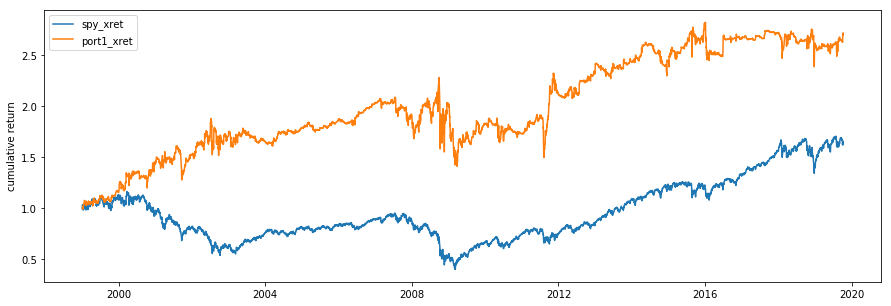

In [15]:
# Assume that we start to use this strategy at the first day of 1999
value_spy = (summary_df['spy_xret']+1).cumprod()
value_port = (summary_df['port1_xret']+1).cumprod()

plt.figure(figsize=(15,5))
plt.plot(value_spy)
plt.plot(value_port)
plt.legend()
plt.ylabel('cumulative return')

According to the summary table and figure, Buy and Hold Market Portfolio performed better than the MeanR_VOL Strategy from the whole time horizon. During the period of 2001 and 2007, MeanR_VOL Strategy had better performance. for the past decade, MeanR_VOL Strategy didn't perform well.

## Strategy2: MeanR_RET Strategy

Buy the bottom 20% quantile stocks and sell it when it's not included in the botton 40% quantile stocks.

* This is a short-term reversal strategy
* To make this strategy more realistic, I will add one day interval. It's hard to buy a stock at the last second of day after 

In [20]:
# Asset Selection 
def asset_selection_top(data,quantile):
    # The quantile doesn't include the NaN
    data.dropna(inplace=True)
    n = len(data)
    data = data.sort_values(ascending=False)
    x = data[:int(n*quantile)+1].index
    return x

def asset_selection_bottom(data,quantile):
    # The quantile doesn't include the NaN
    data.dropna(inplace=True)
    n = len(data)
    data = data.sort_values(ascending=True)
    x = data[:int(n*quantile)+1].index
    return x

In [21]:
df_t = df.to_period('D')

In [22]:
df_t.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1998-12-28,0.011904,-0.019582,NaN,0.014286,NaN,0.075000,0.004005,-0.024554,NaN,0.018233,...,NaN,NaN,-0.008869,0.042987,-0.023185,NaN,0.001312,NaN,0.037946,NaN
1998-12-29,0.010084,0.042610,NaN,-0.014085,NaN,-0.023256,-0.002660,0.006865,NaN,0.020661,...,NaN,NaN,0.004474,0.048806,-0.023736,NaN,0.026212,NaN,0.022043,NaN
1998-12-30,-0.025790,-0.006386,NaN,0.085714,NaN,0.017857,-0.018667,0.059091,NaN,0.004048,...,NaN,NaN,-0.002869,-0.011375,0.070824,NaN,0.034483,NaN,0.032417,NaN
1998-12-31,-0.028181,0.007712,NaN,0.032895,NaN,0.040936,0.016304,-0.004292,NaN,0.018817,...,NaN,NaN,0.004525,-0.012552,0.028628,NaN,-0.009877,NaN,0.019408,NaN
1999-01-04,0.049209,-0.005102,NaN,-0.095541,NaN,-0.022472,0.068182,-0.034483,NaN,0.032982,...,NaN,NaN,-0.011262,-0.002119,0.023992,NaN,-0.039900,NaN,-0.033067,NaN


In [23]:
asset_pool_sell_20 = [asset_selection_top(df_t.iloc[i],0.20) for i in range(len(df_t)) ]
asset_pool_top_40 = [asset_selection_top(df_t.iloc[i],0.40) for i in range(len(df_t)) ]
asset_pool_buy_20 = [asset_selection_bottom(df_t.iloc[i],0.20) for i in range(len(df_t)) ]
asset_pool_bot_40 = [asset_selection_bottom(df_t.iloc[i],0.40) for i in range(len(df_t)) ]

In [24]:
def asset_pool(ticker_20,ticker_hold,ticker_40):
    ticker = np.array(ticker_20)
    for i in ticker_hold:
        if i in ticker_40:
            ticker = np.hstack([ticker,i])
    tickers = np.unique(ticker)
    return tickers

In [25]:
# Those are assets that we need to buy and sell since the 1999-01-04
asset_sell = [asset_pool(asset_pool_sell_20[i],asset_pool_sell_20[i-1],asset_pool_top_40[i]) for i in range(3,len(df_t))]
asset_buy = [asset_pool(asset_pool_buy_20[i],asset_pool_buy_20[i-1],asset_pool_bot_40[i]) for i in range(3,len(df_t))]

asset_sell = np.insert(asset_pool_sell_20[2],[0],asset_sell)
asset_buy = np.insert(asset_pool_buy_20[2],[0],asset_buy)

In [26]:
# Portflio Return
# At time t, we will buy the bottom 20% stocks and sell top 20% stocks based on their performance at t-2.
# we will not sell or buy back the stock until they are not within the 40% quantile.
stocks_used_ret = df_t[2:]
port_ret2 = []
for i in range(len(stocks_used_ret)-2):
    ret = stocks_used_ret.iloc[i+2]
    buy = ret[asset_buy[i]]
    sell = ret[asset_sell[i]]
    buy_ret = np.sum(buy)/len(buy) 
    sell_ret = -np.sum(sell)/len(sell) 
    ret = buy_ret + sell_ret
    port_ret2.append(ret)

In [27]:
port_ret2 = np.array(port_ret2).reshape(-1,1)
summary_df['port2_ret'] = port_ret2[1:]
summary_df['port2_xret'] = summary_df['port2_ret'] - summary_df['risk_free']
summary_df['port2_value'] = (1+summary_df['port2_xret']).cumprod()

## Performance Summary

#### *During the whole time period from 1999-01-04 to 2009-10-08*

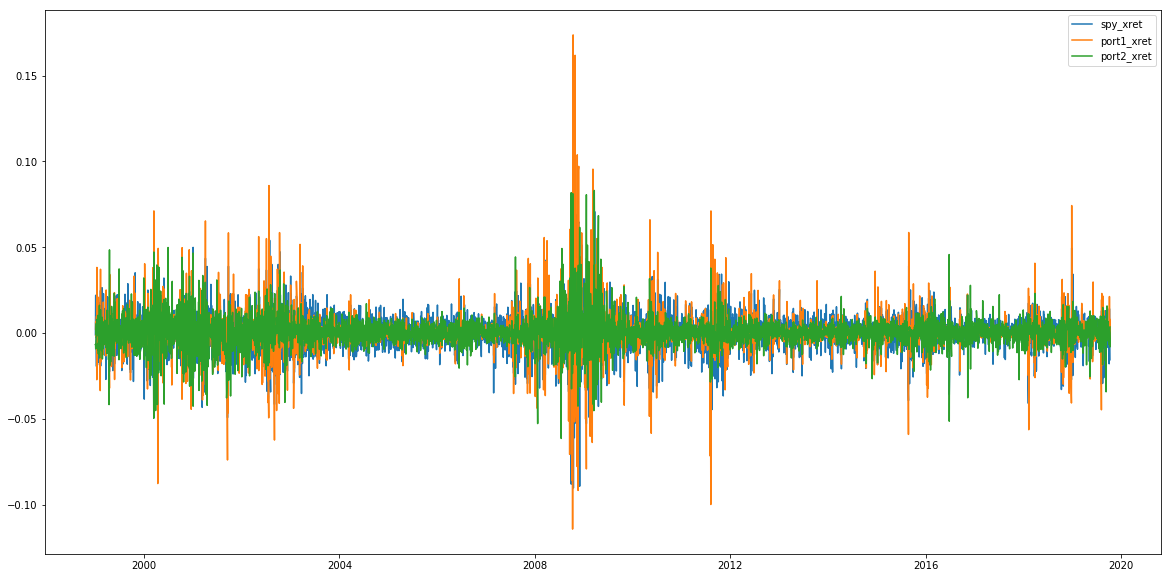

In [29]:
plt.figure(figsize=(20,10))
plt.plot(summary_df['spy_xret'])
plt.plot(summary_df['port1_xret'])
plt.plot(summary_df['port2_xret'])
plt.legend()

Text(0, 0.5, 'cumulative return')

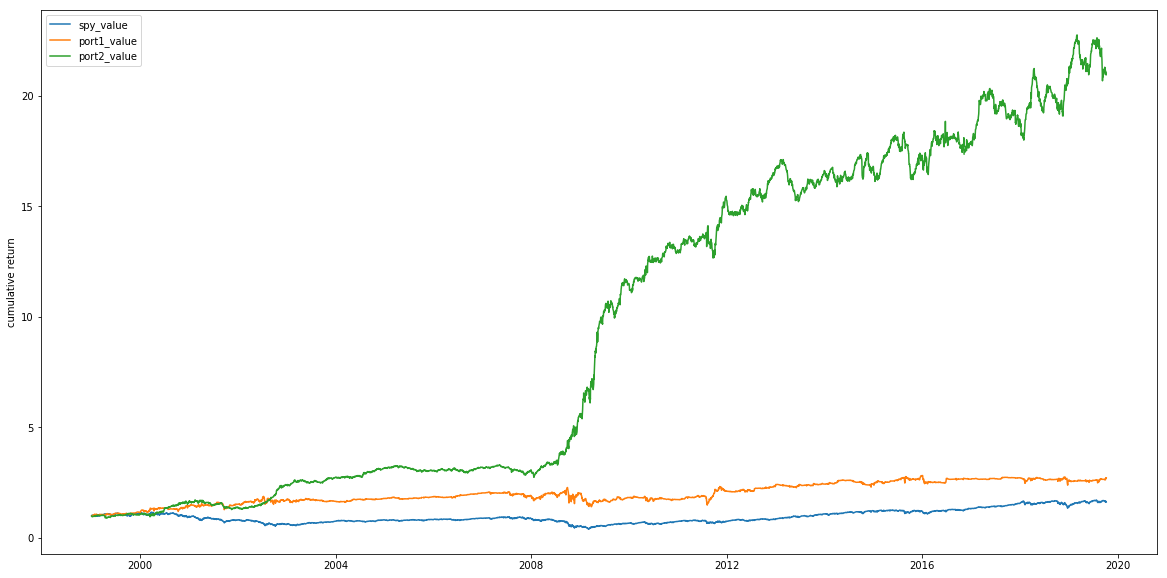

In [30]:
plt.figure(figsize=(20,10))
plt.plot(summary_df['spy_value'])
plt.plot(summary_df['port1_value'])
plt.plot(summary_df['port2_value'])
plt.legend()
plt.ylabel('cumulative return')

In [31]:
describePerformance(summary_df[['spy_xret','port1_xret','port2_xret']])

,spy_xret,port1_xret,port2_xret
mean,0.000164,0.000258,0.000622
std,0.011929,0.011435,0.008786
min,-0.090359,-0.114289,-0.061469
max,0.115792,0.173688,0.083053
ann_std,0.188608,0.180801,0.138912
ann_ret (%),2.355676,4.903799,15.685668
sharpe,0.217984,0.356819,1.119729
fracpos,0.527847,0.503349,0.534545
VaR,-0.018703,-0.013405,-0.011427
CVaR,-0.028493,-0.027451,-0.019299


Analysis: Compare these three portfolios, the second portfolio performed best especially after 2008. The Short-term Reversal Return-Based Asset Selection portfolio obtained the lowest maxmium drowdown with highest annual rate of return.

#### *Divide the 10 years into three different periods: before 2007, during 2007~2008, 2009~current*

In [32]:
# Find the performance of three portfolio before 2007
summary_before_2007 = summary_df.truncate(after=pd.Timestamp('2007-01-01'))

describePerformance(summary_before_2007[['spy_xret','port1_xret','port2_xret']])

,spy_xret,port1_xret,port2_xret
mean,0.000008,0.000411,0.000623
std,0.011324,0.010302,0.009248
min,-0.058502,-0.087753,-0.049729
max,0.057261,0.085892,0.049796
ann_std,0.179045,0.162881,0.146229
ann_ret (%),-1.395319,9.253219,15.568088
sharpe,0.010755,0.631524,1.064803
fracpos,0.508702,0.519145,0.542019
VaR,-0.018375,-0.013387,-0.013536
CVaR,-0.024815,-0.025214,-0.021755


Text(0, 0.5, 'cumulative return')

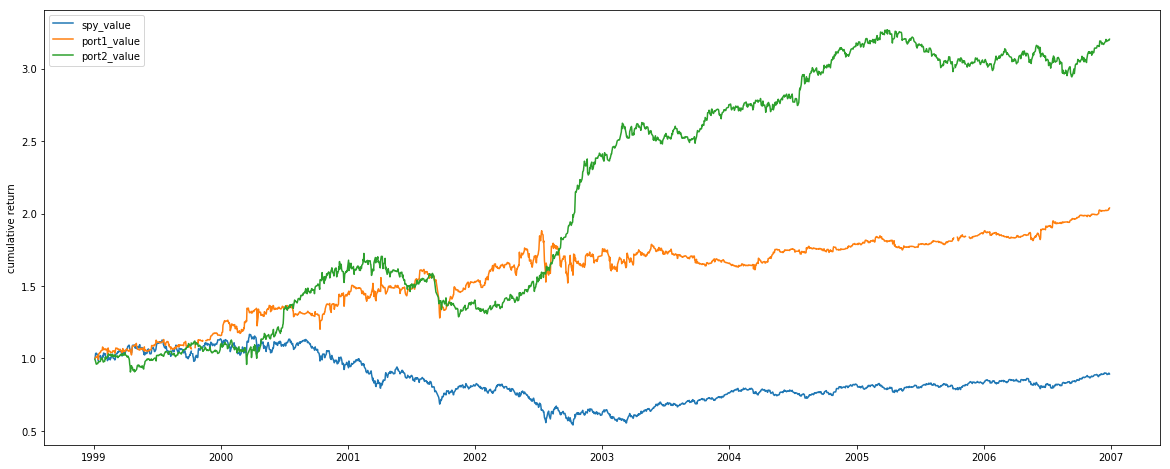

In [33]:
summary_before_2007[['spy_value','port1_value','port2_value']] = (1+summary_before_2007[['spy_xret','port1_xret','port2_xret']]).cumprod()

plt.figure(figsize=(20,8))
plt.plot(summary_before_2007['spy_value'])
plt.plot(summary_before_2007['port1_value'])
plt.plot(summary_before_2007['port2_value'])
plt.legend()
plt.ylabel('cumulative return')

In [34]:
# Find the performance of three portfolio during 2007~2008
summary_2007_2008 = summary_df.truncate(before=pd.Timestamp('2007-01-01'),after=pd.Timestamp('2008-12-31'))

describePerformance(summary_2007_2008[['spy_xret','port1_xret','port2_xret']])

,spy_xret,port1_xret,port2_xret
mean,-0.000815,0.000209,0.001192
std,0.019619,0.021238,0.012326
min,-0.090359,-0.114289,-0.061469
max,0.115792,0.173688,0.081779
ann_std,0.310204,0.335804,0.194890
ann_ret (%),-22.273892,-0.285545,32.200131
sharpe,-0.656874,0.155716,1.529403
fracpos,0.517857,0.500000,0.531746
VaR,-0.029791,-0.024078,-0.014593
CVaR,-0.049537,-0.049362,-0.024976


Text(0, 0.5, 'cumulative return')

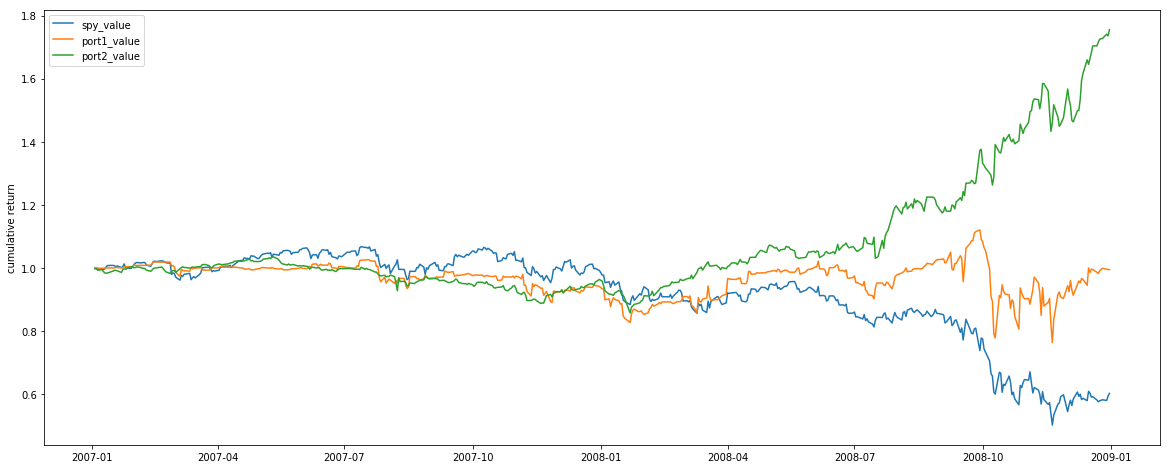

In [35]:
summary_2007_2008[['spy_value','port1_value','port2_value']] = (1+summary_2007_2008[['spy_xret','port1_xret','port2_xret']]).cumprod()

plt.figure(figsize=(20,8))
plt.plot(summary_2007_2008['spy_value'])
plt.plot(summary_2007_2008['port1_value'])
plt.plot(summary_2007_2008['port2_value'])
plt.legend()
plt.ylabel('cumulative return')

In [36]:
# Find the performance of three portfolio after 2008
summary_begin_2009 = summary_df.truncate(before=pd.Timestamp('2008-12-01'))

describePerformance(summary_begin_2009[['spy_xret','port1_xret','port2_xret']])

,spy_xret,port1_xret,port2_xret
mean,0.000466,0.000190,0.000577
std,0.010674,0.009621,0.007755
min,-0.089296,-0.099952,-0.051419
max,0.070750,0.095483,0.083053
ann_std,0.168768,0.152127,0.122613
ann_ret (%),10.746141,3.642019,14.625963
sharpe,0.690150,0.312871,1.175604
fracpos,0.543924,0.491581,0.530747
VaR,-0.017035,-0.010918,-0.009756
CVaR,-0.026422,-0.023574,-0.015750


Text(0, 0.5, 'cumulative return')

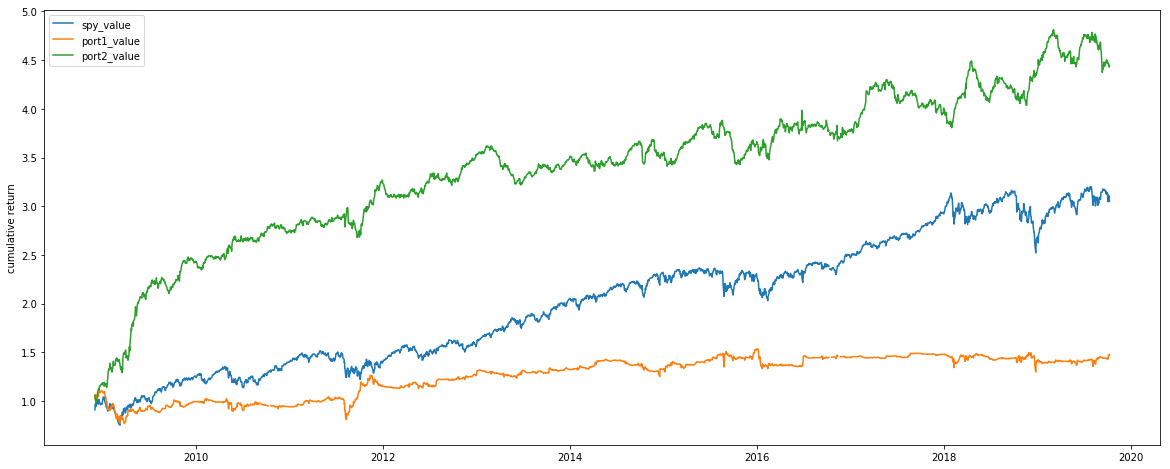

In [39]:
summary_begin_2009[['spy_value','port1_value','port2_value']] = (1+summary_begin_2009[['spy_xret','port1_xret','port2_xret']]).cumprod()

plt.figure(figsize=(20,8))
plt.plot(summary_begin_2009['spy_value'])
plt.plot(summary_begin_2009['port1_value'])
plt.plot(summary_begin_2009['port2_value'])
plt.legend()
plt.ylabel('cumulative return')